<center>
<h2>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h2>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones 2020</h3>
<h3>Predicción de la Calidad de Servicio</h3>
<h3>Análisis y Curación</h3>
</center>
</left>
<h4>Mentor: Martín Hunziker</h4>

[Link Mentoria](https://sites.google.com/view/mentorias2020-diplodatos/ciencia-de-datos-aplicada-en-la-distribuci%C3%B3n-de-energ%C3%ADa-el%C3%A9ctrica?authuser=0).

</left>
</left>

### Introducción

En la siguiente notebook, se presentará la consigna a seguir para el segundo práctico de la materia Análisis y Curación. El objetivo consiste en vincular las tablas del dataset, así como iniciar el tratamiento de los datos geográficos.

Como referencia para el análisis geográfico utilizaremos la notebook 2_0_Intro_Variables_georefrenciadas de Ramiro Caro.


In [30]:
# Instalación de librerias en Collab
!pip install geopandas
!apt install libspatialindex-dev
!pip install rtree
!pip install osmnx
!pip install contextily

!wget -nc https://github.com/mahunz/Diplodatos2020/blob/master/Dataset/ENF_6612_2018-12-31_M10_20190529-1610.gdb.7z?raw=true
!apt-get install p7zip
!mkdir -p Dataset
!mv ENF_6612_2018-12-31_M10_20190529-1610.gdb.7z?raw=true ./Dataset/ENF_6612_2018-12-31_M10_20190529-1610.gdb.7z
!7za x ./Dataset/ENF_6612_2018-12-31_M10_20190529-1610.gdb.7z
!mv ENF_6612_2018-12-31_M10_20190529-1610.gdb ./Dataset/ENF_6612_2018-12-31_M10_20190529-1610.gdb

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libspatialindex-dev is already the newest version (1.8.5-5).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
--2020-08-09 18:39:19--  https://github.com/mahunz/Diplodatos2020/blob/master/Dataset/ENF_6612_2018-12-31_M10_20190529-1610.gdb.7z?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/mahunz/Diplodatos2020/raw/master/Dataset/ENF_6612_2018-12-31_M10_20190529-1610.gdb.7z [following]
--2020-08-09 18:39:19--  https://github.com/mahunz/Diplodatos2020/raw/master/Dataset/ENF_6612_2018-12-31_M10_20190529-1610.gdb.7z
Reusing existing connection to github.com:443.
HTTP request sent, awaiting re

### I. Rutina de Curación

Inicialmente, con el objetivo de preparar los datos que alimentarán futuros modelos de aprendizaje automático (ML), se propone seguir la siguiente __[checklist](https://dimewiki.worldbank.org/wiki/Checklist:_Data_Cleaning)__ para la limpieza de los datos de nuestro proyecto. Esta _checklist_ es la misma que utilizaron en el primer práctico de la materia y nos será de utilidad como guía para curar el dataset. A modo de ayuda, **en esta notebook encontrarán una especie de template** que sigue la _checklist_ y que deberán ir completando.

**Cada decisión tomada deberá quedar registrada de manera explícita y clara.** Luego de pasar por todos los puntos de la _checklist_ propuesta, deberán almacenar en un nuevo archivo los datos resultantes.


### II. Análisis del Contenido

Una vez aplicado el  _Checklist_, lo que vamos a hacer es comenzar a vincular las diferentes tablas del dataset e iniciar la generación de features geográficas


# Resolución

## I. Rutina de Curación

### 1. Importación de Datos

#### 1.1. Verificación de Inexistencia de Problemas en la Importación

A partir de este punto, utilizaremos los transformadores de distribucion como elemnto de analisis tabla UNTRD, e incorporaremos datos de consumidores, subestación y líneas de distribución.

Para comenzar, importamos los datos que vamos a procesar de las diferentes tablas que vamos a analizar:

In [31]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString
import sklearn
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'

In [32]:
# Editar con el path correspondiente a sus datos
data_path = './Dataset/ENF_6612_2018-12-31_M10_20190529-1610.gdb'

In [33]:
untrd = gpd.read_file(data_path, driver='FileGDB', layer='UNTRD')
untrd.shape, untrd.columns

((3879, 33),
 Index(['COD_ID', 'DIST', 'PAC_1', 'PAC_2', 'PAC_3', 'FAS_CON_P', 'FAS_CON_S',
        'FAS_CON_T', 'SIT_ATIV', 'TIP_UNID', 'POS', 'ATRB_PER', 'TEN_LIN_SE',
        'CAP_ELO', 'CAP_CHA', 'TAP', 'CONF', 'POSTO', 'POT_NOM', 'PER_FER',
        'PER_TOT', 'DAT_CON', 'CTMT', 'UNI_TR_S', 'SUB', 'CONJ', 'MUN', 'BANC',
        'TIP_TRAFO', 'MRT', 'DESCR', 'ARE_LOC', 'geometry'],
       dtype='object'))

In [34]:
untrs = gpd.read_file(data_path, driver='FileGDB', layer='UNTRS')
untrs.shape, untrs.columns

((6, 53),
 Index(['COD_ID', 'SUB', 'BARR_1', 'BARR_2', 'BARR_3', 'PAC_1', 'PAC_2',
        'PAC_3', 'DIST', 'FAS_CON_P', 'FAS_CON_S', 'FAS_CON_T', 'SIT_ATIV',
        'TIP_UNID', 'POS', 'POT_NOM', 'POT_F01', 'POT_F02', 'PER_FER',
        'PER_TOT', 'BANC', 'DAT_CON', 'CONJ', 'MUN', 'TIP_TRAFO', 'ALOC_PERD',
        'ENES_01', 'ENES_02', 'ENES_03', 'ENES_04', 'ENES_05', 'ENES_06',
        'ENES_07', 'ENES_08', 'ENES_09', 'ENES_10', 'ENES_11', 'ENES_12',
        'ENET_01', 'ENET_02', 'ENET_03', 'ENET_04', 'ENET_05', 'ENET_06',
        'ENET_07', 'ENET_08', 'ENET_09', 'ENET_10', 'ENET_11', 'ENET_12',
        'DESCR', 'ARE_LOC', 'geometry'],
       dtype='object'))

In [35]:
ssmt = gpd.read_file(data_path, driver='FileGDB', layer='SSDMT')
ssmt.shape, ssmt.columns

((24929, 24),
 Index(['COD_ID', 'PN_CON_1', 'PN_CON_2', 'CTMT', 'UNI_TR_S', 'SUB', 'CONJ',
        'DIST', 'PAC_1', 'PAC_2', 'FAS_CON', 'TIP_CND', 'POS', 'ODI_FAS',
        'TI_FAS', 'ODI_NEU', 'TI_NEU', 'COMP', 'DESCR', 'SITCONTFAS',
        'SITCONTNEU', 'ARE_LOC', 'Shape_Length', 'geometry'],
       dtype='object'))

In [36]:
segcon = gpd.read_file(data_path, driver='FileGDB', layer='SEGCON')
segcon.shape, segcon.columns

((90, 40),
 Index(['COD_ID', 'DIST', 'GEOM_CAB', 'FORM_CAB', 'MAT_FAS_1', 'MAT_FAS_2',
        'MAT_FAS_3', 'MAT_NEU', 'ISO_FAS_1', 'ISO_FAS_2', 'ISO_FAS_3',
        'ISO_NEU', 'CND_FAS', 'R1', 'X1', 'FTRCNV', 'CNOM', 'CMAX', 'CM_FAS',
        'TUC_FAS', 'A1_FAS', 'A2_FAS', 'A3_FAS', 'A4_FAS', 'A5_FAS', 'A6_FAS',
        'CM_NEU', 'TUC_NEU', 'A1_NEU', 'A2_NEU', 'A3_NEU', 'A4_NEU', 'A5_NEU',
        'A6_NEU', 'DESCR', 'BIT_FAS_1', 'BIT_FAS_2', 'BIT_FAS_3', 'BIT_NEU',
        'geometry'],
       dtype='object'))

In [37]:
ucbt = gpd.read_file(data_path, driver='FileGDB', layer='UCBT')
ucbt.shape, ucbt.columns

((108346, 40),
 Index(['DIST', 'PAC', 'PN_CON', 'UNI_TR_D', 'CTMT', 'UNI_TR_S', 'SUB', 'CONJ',
        'MUN', 'BRR', 'CEP', 'CLAS_SUB', 'CNAE', 'TIP_CC', 'FAS_CON', 'GRU_TEN',
        'TEN_FORN', 'GRU_TAR', 'SIT_ATIV', 'DAT_CON', 'CAR_INST', 'LIV',
        'ENE_01', 'ENE_02', 'ENE_03', 'ENE_04', 'ENE_05', 'ENE_06', 'ENE_07',
        'ENE_08', 'ENE_09', 'ENE_10', 'ENE_11', 'ENE_12', 'DIC', 'FIC',
        'SEMRED', 'DESCR', 'ARE_LOC', 'geometry'],
       dtype='object'))

In [38]:
# Agrupando Variables

ucbt['ENE_MED'] = ucbt[['ENE_01', 'ENE_02', 'ENE_03', 'ENE_04', 'ENE_05', 'ENE_06', 'ENE_07','ENE_08', 'ENE_09', 'ENE_10', 'ENE_11', 'ENE_12']].mean(axis=1)
ucbt['ENE_STD'] = ucbt[['ENE_01', 'ENE_02', 'ENE_03', 'ENE_04', 'ENE_05', 'ENE_06', 'ENE_07','ENE_08', 'ENE_09', 'ENE_10', 'ENE_11', 'ENE_12']].std(axis=1)
ucbt['ENE_MAX'] = ucbt[['ENE_01', 'ENE_02', 'ENE_03', 'ENE_04', 'ENE_05', 'ENE_06', 'ENE_07','ENE_08', 'ENE_09', 'ENE_10', 'ENE_11', 'ENE_12']].max(axis=1)

### 1.2. Asegurar la Existencia de IDs o Claves Únicas

El siguiente paso implica chequear que no existen datos duplicados y que las claves, si existen, son únicas.

Las claves únicas de las diferentes tablas es el COD_ID, como figura en la documentación. En el caso de la tabla UCBT fue eliminado por el proveedor de los datos por lo que asumiremos que los datos son únicos. Podriamos regenerar el COD_ID con un valor secuencial, pero como vamos a utilizar la tabla UNTRD como elementos de análisis no será necesario

In [39]:
print(untrd['COD_ID'].is_unique)
print(untrs['COD_ID'].is_unique)
print(ssmt['COD_ID'].is_unique)
print(segcon['COD_ID'].is_unique)

True
True
True
True


Como podemos observar las claves COD_ID en los diferentes Dataframes son únicas.

### 1.3. Despersonalizar Datos y Guardarlos en un Nuevo Archivo

En este caso, no es necesario despersonalizar ningún dato, dado que los mismos ya se encuentran despersonalizados.

### 1.4. Nunca Modificar los Datos Crudos u Originales

Al finalizar la limpieza, deberán guardar el dataset resultante, para asegurarse de no modificar los datos originales.

## 2. Pasos de Limpieza Necesarios

### 2.1. Etiquetas de Variables/Columnas y Problemas de Codificación/Encoding

El geopandas automáticamente detecta el encoding de los datos. 

### 2.2. Tratamiento de Valores Faltantes

Para analizar los valores faltantes, primero deberán saber cuántos existen por campo y cuánto representan del total:

### 2.3. Codificación de Variables Categóricas

Aplica?

Para este punto, las variables que consideramos relevantes a codificar son las siguientes variables:
    -ARE_LOC, el tipo de area.
    -GRU_TAR, el grupo tarifario

In [40]:
from sklearn import preprocessing
datasets = {'untrd': untrd, 'ucbt': ucbt}
columns_to_encode = ['ARE_LOC', 'GRU_TAR']

for key, dataset in datasets.items():
    for column in columns_to_encode:
        if column in dataset:
            le = preprocessing.LabelEncoder()
            le.fit(dataset[column])
            dataset[column] = le.transform(dataset[column])

### 2.4. No Cambiar los Nombres de las Variables de la Fuente de Origen

No aplica.

### 2.5. Verificación de Consistencia de Datos

Este es el paso más analítico, en donde se deben aplicar reglas de integridad.

Para este paso vamos a verificar la integridad de la entidad:
    -Que no existan claves repetidas(es decir atributos COD_ID). Anteriormente hemos observado que estos atributos son únicos.
    -Además vamos a eliminar las filas que tengan algun valor Nan. 


In [41]:
untrd = untrd.dropna()
untrs = untrs.dropna()
ssmt = ssmt.dropna()
segcon = segcon.dropna()
ucbt = ucbt.dropna()

### 2.6. Identificar y Documentar Valores Atípicos/Outliers

Calcular estadísticos.

In [42]:
def find_outliers(dataset, column_name):
    interesting_col = dataset[column_name]
    CI =  (interesting_col.quantile(0.75)-interesting_col.quantile(0.25))
    mask_outlier = (
        np.abs(interesting_col - interesting_col.median()) >= (1.5 * CI))
    return dataset[mask_outlier]


main_statisticians = ['FIC', 'DIC', 'ENE_MED']

outliers = []
for key, dataset in datasets.items():
    print("Dataset: ", key)
    for column in main_statisticians:
        if column in dataset:
            outliers = find_outliers(dataset, column)
            row_quantity = dataset.shape[0]
            print("Cantidad de outliers para la variable ", column, len(outliers))
    print("------------------------------------------------")

Dataset:  untrd
------------------------------------------------
Dataset:  ucbt
Cantidad de outliers para la variable  FIC 12360
Cantidad de outliers para la variable  DIC 15122
Cantidad de outliers para la variable  ENE_MED 8363
------------------------------------------------


In [43]:
# Procedemos a limpiar los outliers para la layer ucbt
def clean_outliers(dataset, column_name):
    interesting_col = dataset[column_name]
    CI =  (interesting_col.quantile(0.75)-interesting_col.quantile(0.25))
    mask_outlier = (
        np.abs(interesting_col - interesting_col.median()) <= (1.5 * CI))
    return dataset[mask_outlier]


for column in main_statisticians:
    ucbt_without_outliers = clean_outliers(ucbt, column)
datasets['ucbt'] = ucbt_without_outliers


### 2.7. Evaluar Cómo Comprimir los Datos Para su Almacenamiento Más Eficiente

No aplica.

### 2.8. Guardar el Set de Datos con un Nombre Informativo

No aplica.

## 3. Pasos de Limpieza Deseables

### 3.1. Ordenar Variables/Columnas

No Aplica

### 3.2. Quitar Variables/Columnas Irrelevantes

Tenemos alguna en este caso?

Por el momento, para la layer "ucbt", nos quedaremos solamente con:
    
    -GRU_TAR
    -UNI_TR_D
    -UNI_TR_S 
    -DIC
    -FIC
    -ENE_MED
    -ENE_STD
    -ENE_MAX

Para la "layer" untrd, nos quedaremos con las siguientes variables:

    -COD_ID
    -UNI_TR_S
    -ARE_LOC
    -geometry

In [44]:
datasets['ucbt'].drop(datasets['ucbt'].columns.difference(['GRU_TAR', 'UNI_TR_D', 'UNI_TR_S', 'DIC', 'FIC', 'ENE_MED', 'ENE_MAX']), 1, inplace=True)

In [45]:
datasets['untrd'].drop(datasets['untrd'].columns.difference(['COD_ID', 'UNI_TR_S', 'ARE_LOC', 'geometry']), 1, inplace=True)

### 3.3. Renombrar Variables de Grillas

No aplica.

### 3.4. Categorizar Variables que Contengan “Otros”

No aplica.

### 3.5. Agregar Metadata a los Datos

No aplica.

## II. Análisis  Contenido

### 1. Features Tipo Objetos

In [46]:
import scipy as sc
datasets['ucbt'] = datasets['ucbt'].groupby(['UNI_TR_D']).agg(GRU_TAR=('GRU_TAR',lambda x: sc.stats.mode(x)[0]),
                                                              DIC=('DIC',np.sum),FIC=('FIC',np.sum),ENE_MED=('ENE_MED',np.mean),
                                                              ENE_MAX=('ENE_MAX',np.sum)).reset_index()
datasets['ucbt']

,UNI_TR_D,GRU_TAR,DIC,FIC,ENE_MED,ENE_MAX
0,,1,36.66,10.0,29.750000,2890.0
1,101415715,1,76.55,28.0,97.791667,372.0
2,102321736,1,17.18,7.0,1.000000,5.0
3,103455355,1,8.31,7.0,91.333333,116.0
4,105138826,1,16.10,12.0,13.583333,35.0
...,...,...,...,...,...,...
3331,92651766,1,14.10,6.0,2.300000,57.0
3332,96872663,1,63.58,20.0,8.083333,30.0
3333,96997174,1,59.51,18.0,36.916667,49.0
3334,97134637,1,20.91,11.0,112.416667,221.0


## Consumidores

1 - A partir de los resultados obtenidos en el práctico 1 seleccione que features podrían ser relevantes para la predicción de la calidad de servicio.

2 - Agrupe los datos en base a la variable UNI_TR_D.

3 - Justifique los métodos utilizados para agrupar las variables numéricas y categóricas.

Para agrupar los datos, utilizamos la funcion "groupby", en donde agrupamos por la variable UNI_TR_D y a las demas columnas que teniamos decidimos agruparlas por lo siguiente:

    -GRU_TAR: tomamos su moda
    -DIC: calculamos su suma
    -FIC: calculamos su suma
    -ARE_LOC: tomamos su moda
    -ENE_MED: calculamos su promedio
    -ENE_MAX: calculamos su suma

## Subestación

4 - Analice la información disponible sobre los transformadores de las Subestaciones (UNI_TR_S > UNTRS)

5 - Seleccione las variables relevantes, realice un tratamiento de valores invalidos y outliers correspondientes. Agrupe los valores por UNTRD y agregue al dataset.

In [47]:
datasets['untrd']

,COD_ID,UNI_TR_S,ARE_LOC,geometry
0,26877970,27707625,0,POINT (-42.59528 -22.19312)
1,26877971,27707625,0,POINT (-42.59618 -22.19249)
2,26877972,27707625,0,POINT (-42.59800 -22.19074)
3,26877973,27707625,0,POINT (-42.60002 -22.18566)
4,26877974,27707625,0,POINT (-42.60887 -22.20177)
...,...,...,...,...
3874,26876494,27707534,0,POINT (-42.32841 -22.37498)
3875,26876495,27707534,0,POINT (-42.31524 -22.31688)
3876,26876496,27707534,0,POINT (-42.30362 -22.31482)
3877,26876497,27707534,0,POINT (-42.30930 -22.37747)


In [48]:
untrd_with_ucbt_grouped = datasets['ucbt'].merge(datasets['untrd'], left_on='UNI_TR_D', right_on='COD_ID')
untrd_with_ucbt_grouped = untrd_with_ucbt_grouped.drop(['COD_ID'], axis=1)
untrd_with_ucbt_grouped.rename(columns={"geometry": "geometry_untrd"}, inplace=True)
untrd_with_ucbt_grouped

,UNI_TR_D,GRU_TAR,DIC,FIC,ENE_MED,ENE_MAX,UNI_TR_S,ARE_LOC,geometry_untrd
0,101415715,1,76.55,28.0,97.791667,372.0,27707534,0,POINT (-42.46342 -22.40186)
1,102321736,1,17.18,7.0,1.000000,5.0,27707625,0,POINT (-42.52059 -22.18586)
2,103455355,1,8.31,7.0,91.333333,116.0,27707534,1,POINT (-42.33438 -22.35449)
3,105138826,1,16.10,12.0,13.583333,35.0,27707534,0,POINT (-42.30769 -22.36775)
4,105383366,1,4.25,25.0,103.660000,3770.0,27708102,1,POINT (-42.53134 -22.28409)
...,...,...,...,...,...,...,...,...,...
3329,92651766,1,14.10,6.0,2.300000,57.0,27707861,0,POINT (-42.47835 -22.26553)
3330,96872663,1,63.58,20.0,8.083333,30.0,27707750,0,POINT (-42.63851 -22.29795)
3331,96997174,1,59.51,18.0,36.916667,49.0,27707534,0,POINT (-42.35905 -22.32697)
3332,97134637,1,20.91,11.0,112.416667,221.0,27707750,0,POINT (-42.58764 -22.29391)


In [49]:
#Por ahora de la layer untrs, tomaremos solamente su id, que es la columna COD_ID y su punto geométrico.
untrs_without_irrelevants_columns = untrs.copy()
untrs_without_irrelevants_columns.drop(untrs.columns.difference(['COD_ID','geometry']), 1, inplace=True)
untrs_without_irrelevants_columns

,COD_ID,geometry
0,27707534,POINT (-42.38024 -22.28705)
1,27707625,POINT (-42.52043 -22.23040)
2,27707750,POINT (-42.68582 -22.26417)
3,27707861,POINT (-42.51374 -22.28512)
4,27708102,POINT (-42.53341 -22.27488)
5,80345241,POINT (-42.53341 -22.27488)


In [50]:
ucbt_untrd_untrs = untrd_with_ucbt_grouped.merge(untrs_without_irrelevants_columns, left_on='UNI_TR_S', right_on='COD_ID')
ucbt_untrd_untrs = ucbt_untrd_untrs.drop(['COD_ID'], axis=1)
ucbt_untrd_untrs.rename(columns={"geometry": "geometry_untrs"}, inplace=True)
ucbt_untrd_untrs

,UNI_TR_D,GRU_TAR,DIC,FIC,ENE_MED,ENE_MAX,UNI_TR_S,ARE_LOC,geometry_untrd,geometry_untrs
0,101415715,1,76.55,28.0,97.791667,372.0,27707534,0,POINT (-42.46342 -22.40186),POINT (-42.38024 -22.28705)
1,103455355,1,8.31,7.0,91.333333,116.0,27707534,1,POINT (-42.33438 -22.35449),POINT (-42.38024 -22.28705)
2,105138826,1,16.10,12.0,13.583333,35.0,27707534,0,POINT (-42.30769 -22.36775),POINT (-42.38024 -22.28705)
3,106512676,1,17.24,8.0,84.833333,101.0,27707534,0,POINT (-42.36098 -22.33090),POINT (-42.38024 -22.28705)
4,108015624,1,19.15,9.0,158.166667,180.0,27707534,0,POINT (-42.35269 -22.33233),POINT (-42.38024 -22.28705)
...,...,...,...,...,...,...,...,...,...,...
3329,62005694,1,1.06,4.0,26.208333,83.0,80345241,1,POINT (-42.55290 -22.32220),POINT (-42.53341 -22.27488)
3330,68553759,1,39.40,63.0,98.020833,3923.0,80345241,1,POINT (-42.55061 -22.33056),POINT (-42.53341 -22.27488)
3331,71641214,1,47.19,39.0,160.950855,8415.0,80345241,1,POINT (-42.54295 -22.32953),POINT (-42.53341 -22.27488)
3332,87219744,1,242.57,146.0,133.132114,8476.0,80345241,1,POINT (-42.54309 -22.30406),POINT (-42.53341 -22.27488)


## Generación de variables geográficas

5 - Calcule la distancia euclideana de cada untrd al correspondiente untrs y adicione al dataset.

6 - Cree una variable que sea la distancia al centro urbano mas cercanos.

7 - Usando OSMnx descargue la informacion sobre caminos dentro del area de cobertura de la distribuidora. Cree variables para las distancias a autopistas (trunk), a caminos primarios (primary) y a caminos secundarios (secondary)


In [51]:
ucbt_untrd_untrs['eu_dis_untrs'] = -1

for i,t in ucbt_untrd_untrs.iterrows():
    eud = ucbt_untrd_untrs.geometry_untrd[i].distance(ucbt_untrd_untrs.geometry_untrs[i])
    ucbt_untrd_untrs.eu_dis_untrs.loc[i] = eud

Tomamos como punto de "centro urbano", el punto geográfico donde se encuentra la central principal de la empresa "Nova Friburgo Energisa".

In [52]:
nova_friburgo_energisa = Point(-42.531941, -22.281767)

ucbt_untrd_untrs['eu_dis_nfe'] = -1

for i,t in ucbt_untrd_untrs.iterrows():
    eud = ucbt_untrd_untrs.geometry_untrd[i].distance(nova_friburgo_energisa)
    ucbt_untrd_untrs.eu_dis_nfe.loc[i] = eud
    
ucbt_untrd_untrs 

,UNI_TR_D,GRU_TAR,DIC,FIC,ENE_MED,ENE_MAX,UNI_TR_S,ARE_LOC,geometry_untrd,geometry_untrs,eu_dis_untrs,eu_dis_nfe
0,101415715,1,76.55,28.0,97.791667,372.0,27707534,0,POINT (-42.46342 -22.40186),POINT (-42.38024 -22.28705),0.141772,0.138264
1,103455355,1,8.31,7.0,91.333333,116.0,27707534,1,POINT (-42.33438 -22.35449),POINT (-42.38024 -22.28705),0.081550,0.210518
2,105138826,1,16.10,12.0,13.583333,35.0,27707534,0,POINT (-42.30769 -22.36775),POINT (-42.38024 -22.28705),0.108510,0.240169
3,106512676,1,17.24,8.0,84.833333,101.0,27707534,0,POINT (-42.36098 -22.33090),POINT (-42.38024 -22.28705),0.047884,0.177878
4,108015624,1,19.15,9.0,158.166667,180.0,27707534,0,POINT (-42.35269 -22.33233),POINT (-42.38024 -22.28705),0.052998,0.186244
...,...,...,...,...,...,...,...,...,...,...,...,...
3329,62005694,1,1.06,4.0,26.208333,83.0,80345241,1,POINT (-42.55290 -22.32220),POINT (-42.53341 -22.27488),0.051173,0.045542
3330,68553759,1,39.40,63.0,98.020833,3923.0,80345241,1,POINT (-42.55061 -22.33056),POINT (-42.53341 -22.27488),0.058273,0.052244
3331,71641214,1,47.19,39.0,160.950855,8415.0,80345241,1,POINT (-42.54295 -22.32953),POINT (-42.53341 -22.27488),0.055476,0.049019
3332,87219744,1,242.57,146.0,133.132114,8476.0,80345241,1,POINT (-42.54309 -22.30406),POINT (-42.53341 -22.27488),0.030737,0.024922


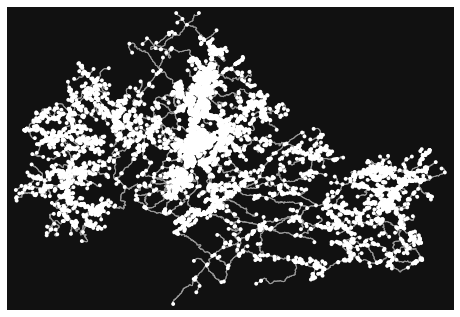

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f25d07484e0>)

In [53]:
import osmnx as ox
import rtree

conj = gpd.read_file(data_path, driver='FileGDB', layer='CONJ')

my_place = 'Nova Friburgo, Rio de Janeiro, Brazil'

G = ox.graph_from_place(my_place)
ox.plot_graph(G)


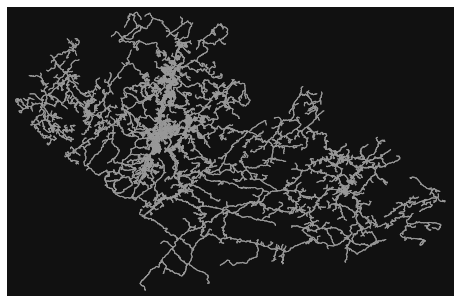

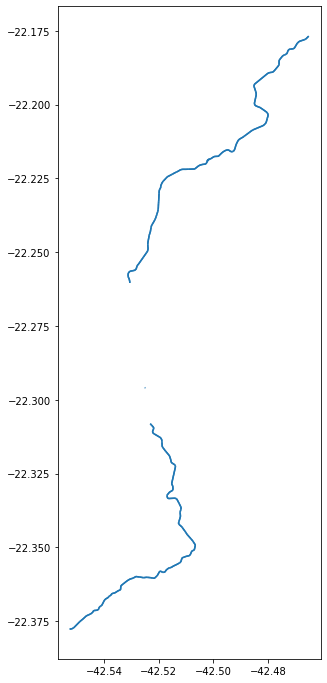

In [54]:
conj_deg = conj
dist = conj_deg.dissolve(by='DIST')
G_conj = ox.graph_from_polygon(dist.to_crs(epsg=4326).iloc[0].geometry)
fig, ax = ox.plot_graph(G_conj, node_size=0)
nodes, edges = ox.graph_to_gdfs(G_conj)
edges.to_csv('edges_conj.csv')
edges[edges.name.str.contains('Rodovia').fillna(False)].plot(figsize=(12,12))
mask_main_roads = (edges.highway.str.contains('trunk').fillna(False) | edges.highway.str.contains('primary').fillna(False))
mask_secondary_roads = (edges.highway.str.contains('trunk').fillna(False) | edges.highway.str.contains('secondary').fillna(False))


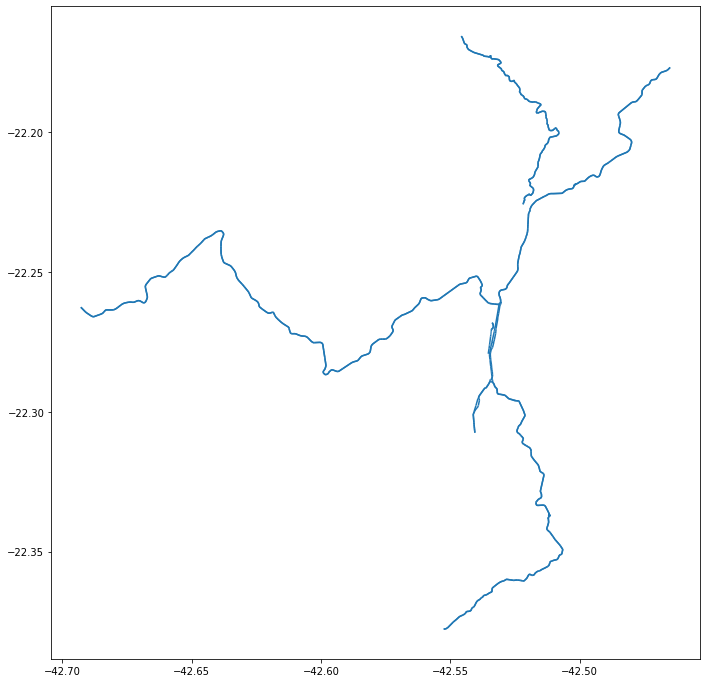

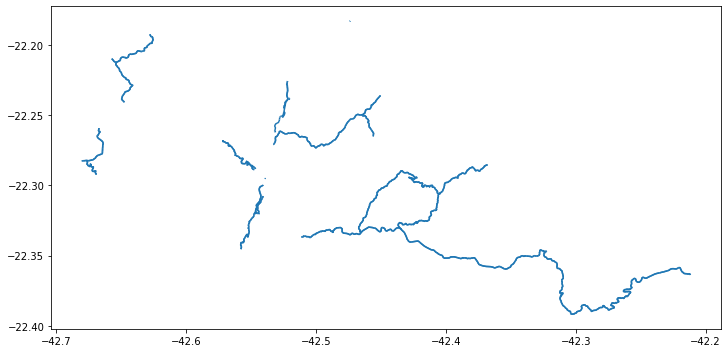

In [55]:
main_roads = edges[['geometry','length','name', 'ref']][mask_main_roads]
secondary_roads = edges[['geometry','length','name', 'ref']][mask_secondary_roads]

main_roads.plot(figsize=(12,12))
secondary_roads.plot(figsize=(12,12))


In [56]:
main_roads['dist'] = 6612
secondary_roads['dist'] = 6612

main_roads_comb = main_roads.dissolve(by='dist')
main_roads_comb.to_crs(epsg=31984, inplace= True)


secondary_roads_comb = secondary_roads.dissolve(by='dist')
secondary_roads_comb.to_crs(epsg=31984, inplace= True)


ucbt_untrd_untrs['main_r_dist'] = -1
ucbt_untrd_untrs['secondary_r_dist'] = -1


for i,t in ucbt_untrd_untrs.iterrows():
    eud_main_roads = ucbt_untrd_untrs.geometry_untrd[i].distance(main_roads_comb.iloc[0].geometry)
    eud_secondary_roads = ucbt_untrd_untrs.geometry_untrd[i].distance(secondary_roads_comb.iloc[0].geometry)
    ucbt_untrd_untrs.main_r_dist.loc[i] = eud_main_roads
    ucbt_untrd_untrs.secondary_r_dist.loc[i] = eud_secondary_roads
ucbt_untrd_untrs

,UNI_TR_D,GRU_TAR,DIC,FIC,ENE_MED,ENE_MAX,UNI_TR_S,ARE_LOC,geometry_untrd,geometry_untrs,eu_dis_untrs,eu_dis_nfe,main_r_dist,secondary_r_dist
0,101415715,1,76.55,28.0,97.791667,372.0,27707534,0,POINT (-42.46342 -22.40186),POINT (-42.38024 -22.28705),0.141772,0.138264,7.522261e+06,7.521795e+06
1,103455355,1,8.31,7.0,91.333333,116.0,27707534,1,POINT (-42.33438 -22.35449),POINT (-42.38024 -22.28705),0.081550,0.210518,7.522261e+06,7.521795e+06
2,105138826,1,16.10,12.0,13.583333,35.0,27707534,0,POINT (-42.30769 -22.36775),POINT (-42.38024 -22.28705),0.108510,0.240169,7.522261e+06,7.521795e+06
3,106512676,1,17.24,8.0,84.833333,101.0,27707534,0,POINT (-42.36098 -22.33090),POINT (-42.38024 -22.28705),0.047884,0.177878,7.522261e+06,7.521795e+06
4,108015624,1,19.15,9.0,158.166667,180.0,27707534,0,POINT (-42.35269 -22.33233),POINT (-42.38024 -22.28705),0.052998,0.186244,7.522261e+06,7.521795e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3329,62005694,1,1.06,4.0,26.208333,83.0,80345241,1,POINT (-42.55290 -22.32220),POINT (-42.53341 -22.27488),0.051173,0.045542,7.522261e+06,7.521795e+06
3330,68553759,1,39.40,63.0,98.020833,3923.0,80345241,1,POINT (-42.55061 -22.33056),POINT (-42.53341 -22.27488),0.058273,0.052244,7.522261e+06,7.521795e+06
3331,71641214,1,47.19,39.0,160.950855,8415.0,80345241,1,POINT (-42.54295 -22.32953),POINT (-42.53341 -22.27488),0.055476,0.049019,7.522261e+06,7.521795e+06
3332,87219744,1,242.57,146.0,133.132114,8476.0,80345241,1,POINT (-42.54309 -22.30406),POINT (-42.53341 -22.27488),0.030737,0.024922,7.522261e+06,7.521795e+06


## [Opcional] Generación de variables con arboles de busqueda

8 - Cree variables que indique la cantidad de consumidores en radios de 25, 50 y 100 metros del transformador.

9 - Cree una variable indicando la distancia media de cada fila (cada untrd) a los 5 untrd mas cercanos.

10 - Usando OSMnx descargue los footprints de edificios disponibles, y cree una variable que indique la cantidad de edificios en un radio de 200 metros al transformador.